In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('spotify-2023.csv', encoding='iso-8859-1')


In [3]:

# Clean Data
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], errors='coerce')
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'], errors='coerce')
df['key'] = df['key'].fillna('Unknown')
df['in_shazam_charts'] = df['in_shazam_charts'].fillna(0)

# Fill NaNs with zero or another appropriate value
df.fillna(0, inplace=True)

# Ensure all columns have finite values
df.replace([float('inf'), float('-inf')], 0, inplace=True)


numeric_columns = df.select_dtypes(include=[np.number]).columns

# Basic statistics
print(df[numeric_columns].describe())

# Check for missing values
print("\nMissing values:")
print(df[numeric_columns].isnull().sum())

       artist_count  released_year  released_month  released_day  \
count    953.000000     953.000000      953.000000    953.000000   
mean       1.556139    2018.238195        6.033578     13.930745   
std        0.893044      11.116218        3.566435      9.201949   
min        1.000000    1930.000000        1.000000      1.000000   
25%        1.000000    2020.000000        3.000000      6.000000   
50%        1.000000    2022.000000        6.000000     13.000000   
75%        2.000000    2022.000000        9.000000     22.000000   
max        8.000000    2023.000000       12.000000     31.000000   

       in_spotify_playlists  in_spotify_charts       streams  \
count            953.000000         953.000000  9.530000e+02   
mean            5200.124869          12.009444  5.135979e+08   
std             7897.608990          19.575992  5.668039e+08   
min               31.000000           0.000000  0.000000e+00   
25%              875.000000           0.000000  1.413817e+08   
50%

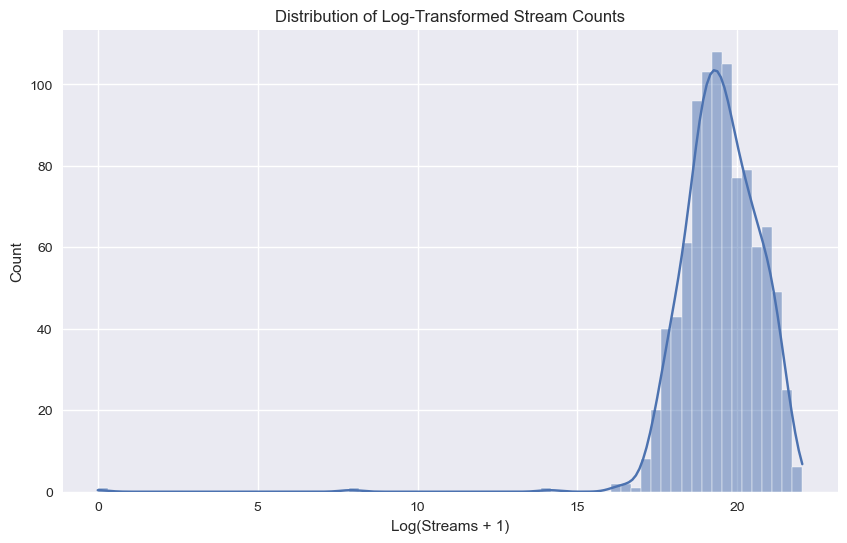

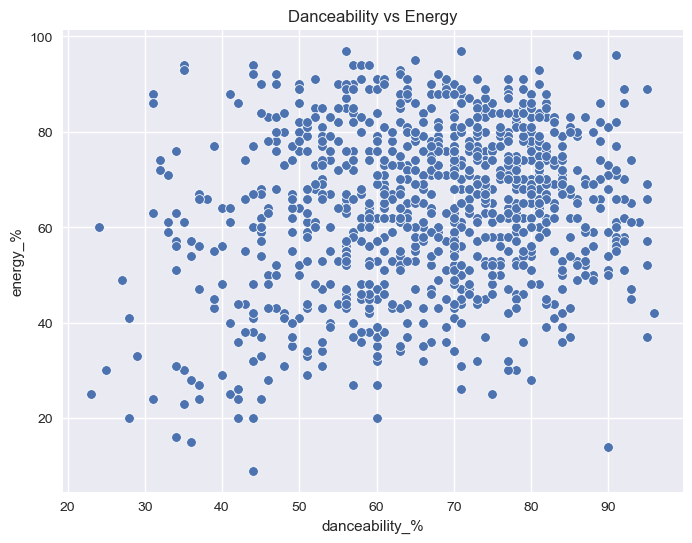

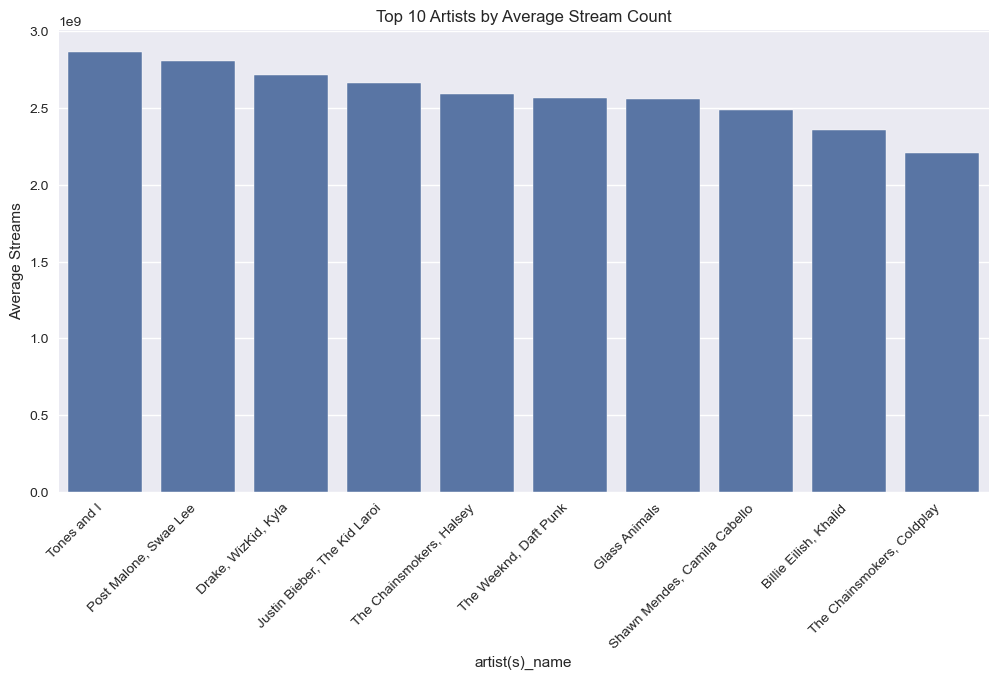

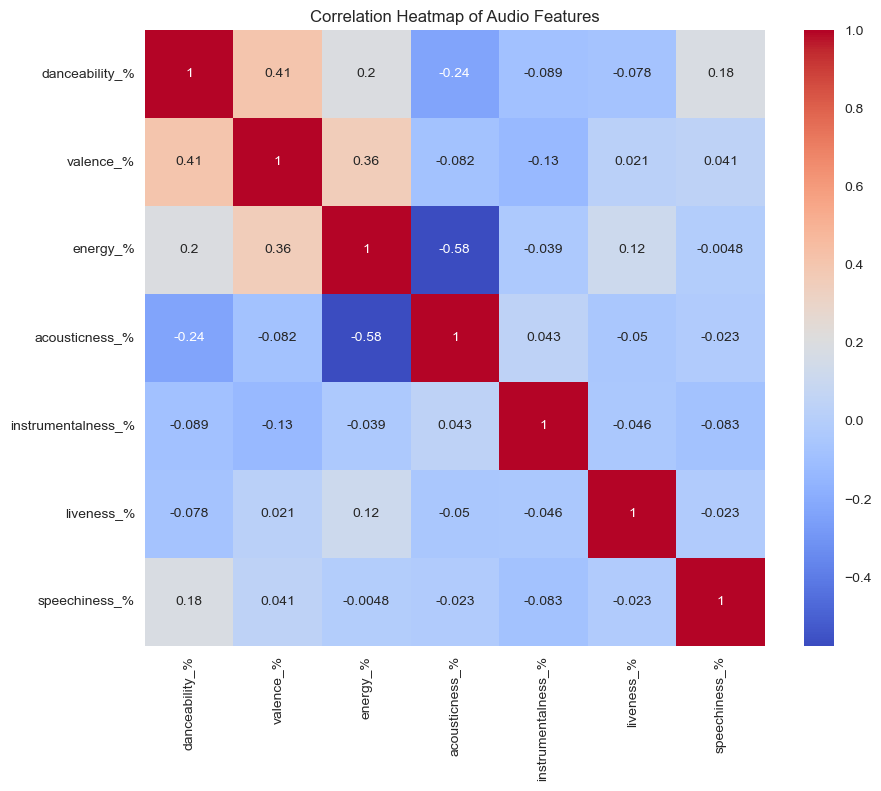

In [39]:

# Set up the plotting style
plt.style.use('seaborn-v0_8')

# 1. Distribution of streams (log-transformed for better visualization)
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['streams']), kde=True)
plt.title('Distribution of Log-Transformed Stream Counts')
plt.xlabel('Log(Streams + 1)')
plt.show()

# 2. Correlation between danceability and energy
plt.figure(figsize=(8, 6))
sns.scatterplot(x='danceability_%', y='energy_%', data=df)
plt.title('Danceability vs Energy')
plt.show()

# 3. Top 10 artists by average stream count
top_artists = df.groupby('artist(s)_name')['streams'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.index, y=top_artists.values)
plt.title('Top 10 Artists by Average Stream Count')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Streams')
plt.show()

# 4. Correlation heatmap of audio features
audio_features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
plt.figure(figsize=(10, 8))
sns.heatmap(df[audio_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Audio Features')
plt.show()

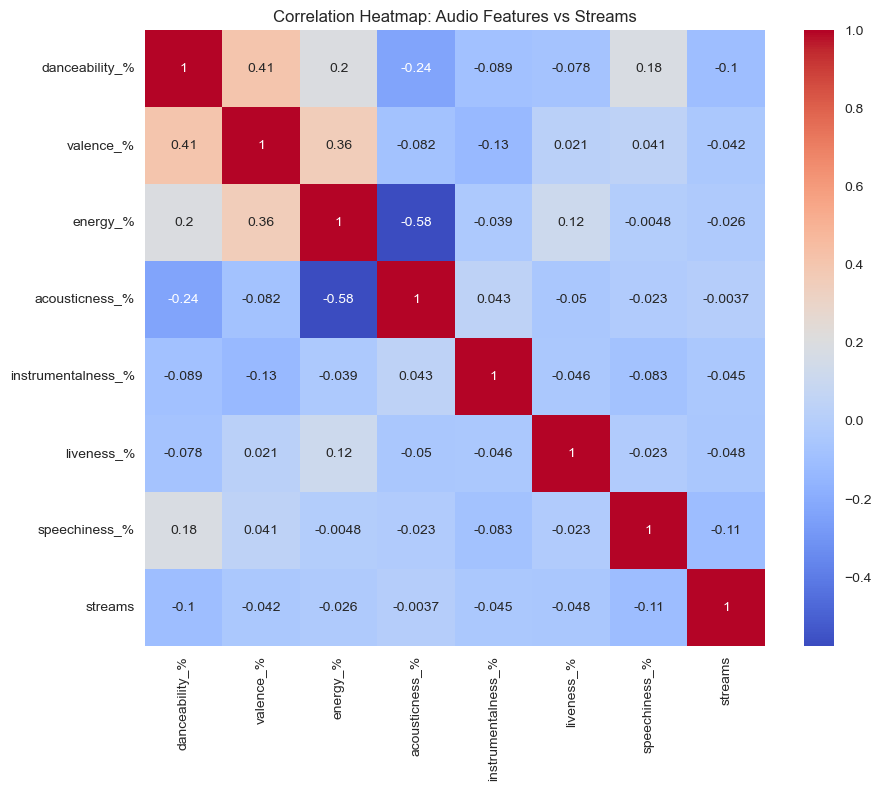

In [40]:
features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'streams']

correlation_matrix = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Audio Features vs Streams')
plt.show()

In [41]:
# Create composite features
# Energy-Danceability Index
df['energy_dance_index'] = (df['energy_%'] + df['danceability_%']) / 2

# Acousticness-Instrumentalness Index
df['acoustic_instrument_index'] = (df['acousticness_%'] + df['instrumentalness_%']) / 2

# Mood Index (combination of valence and energy)
df['mood_index'] = (df['valence_%'] + df['energy_%']) / 2

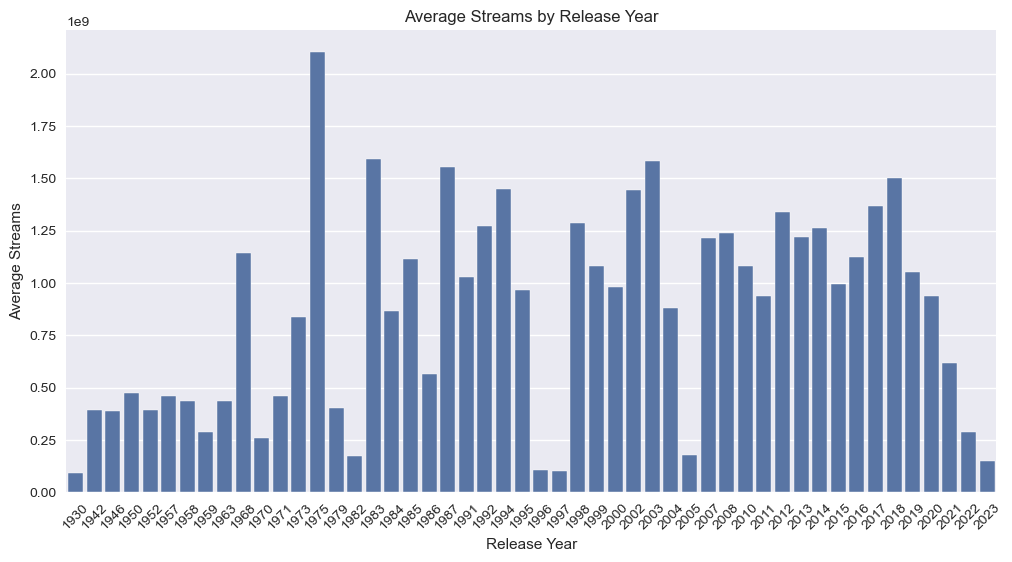

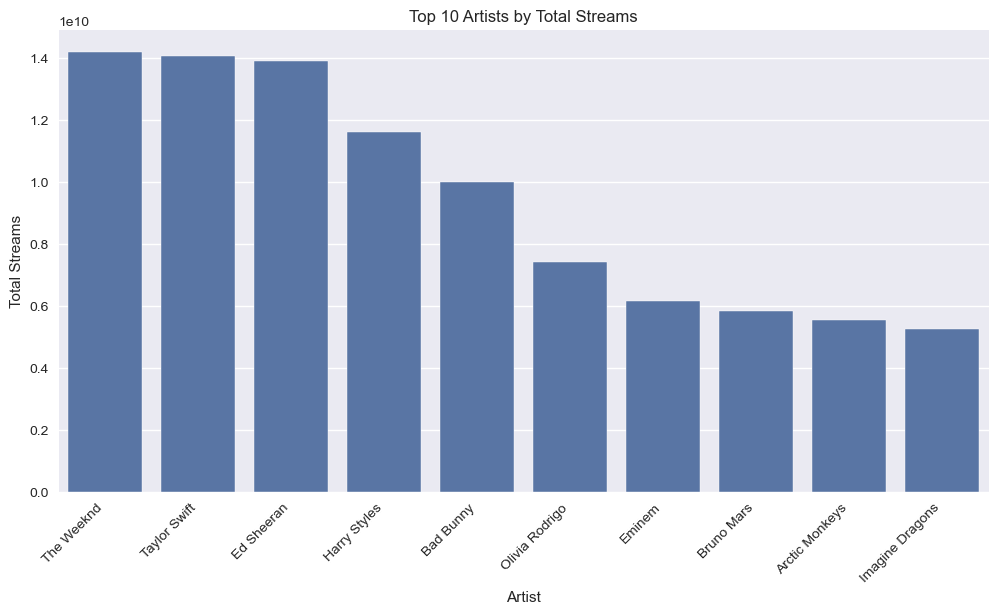

In [42]:
# Explore impact of release date and artist popularity

# Calculate average streams by release year
yearly_streams = df.groupby('released_year')['streams'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='released_year', y='streams', data=yearly_streams)
plt.title('Average Streams by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Average Streams')
plt.xticks(rotation=45)
plt.show()

# Calculate and plot top 10 artists by total streams
top_artists = df.groupby('artist(s)_name')['streams'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.index, y=top_artists.values)
plt.title('Top 10 Artists by Total Streams')
plt.xlabel('Artist')
plt.ylabel('Total Streams')
plt.xticks(rotation=45, ha='right')
plt.show()

Mean Squared Error: 0.2774503420807848
R-squared Score: 0.7251625935723698

Feature Importance:
                      feature  importance
11       in_spotify_playlists    0.549795
10              released_year    0.203801
1                   valence_%    0.057100
0              danceability_%    0.033122
12         in_apple_playlists    0.030878
13        in_deezer_playlists    0.026820
5                  liveness_%    0.017141
6               speechiness_%    0.015193
7          energy_dance_index    0.012687
9                  mood_index    0.012616
3              acousticness_%    0.012088
2                    energy_%    0.012014
8   acoustic_instrument_index    0.008674
4          instrumentalness_%    0.008069


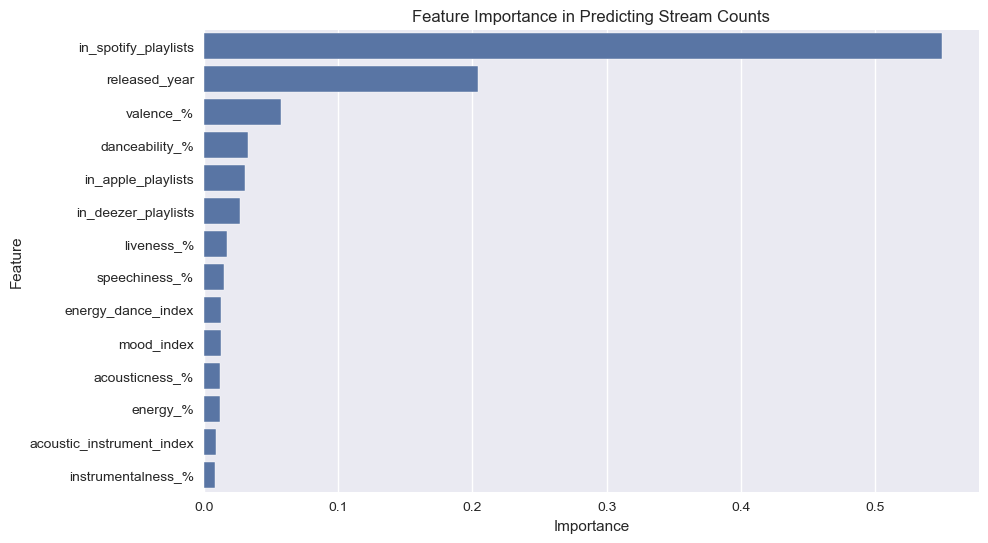

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Prepare features and target
features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
            'liveness_%', 'speechiness_%', 'energy_dance_index', 'acoustic_instrument_index',
            'mood_index', 'released_year', 'in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']

X = df[features]
y = np.log1p(df['streams'])  # Log-transform the target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Stream Counts')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Correlation between audio features and playlist success:
playlist_success      1.000000
energy_%              0.033462
valence_%            -0.020864
instrumentalness_%   -0.028203
liveness_%           -0.046383
acousticness_%       -0.063557
speechiness_%        -0.091828
danceability_%       -0.106950
Name: playlist_success, dtype: float64


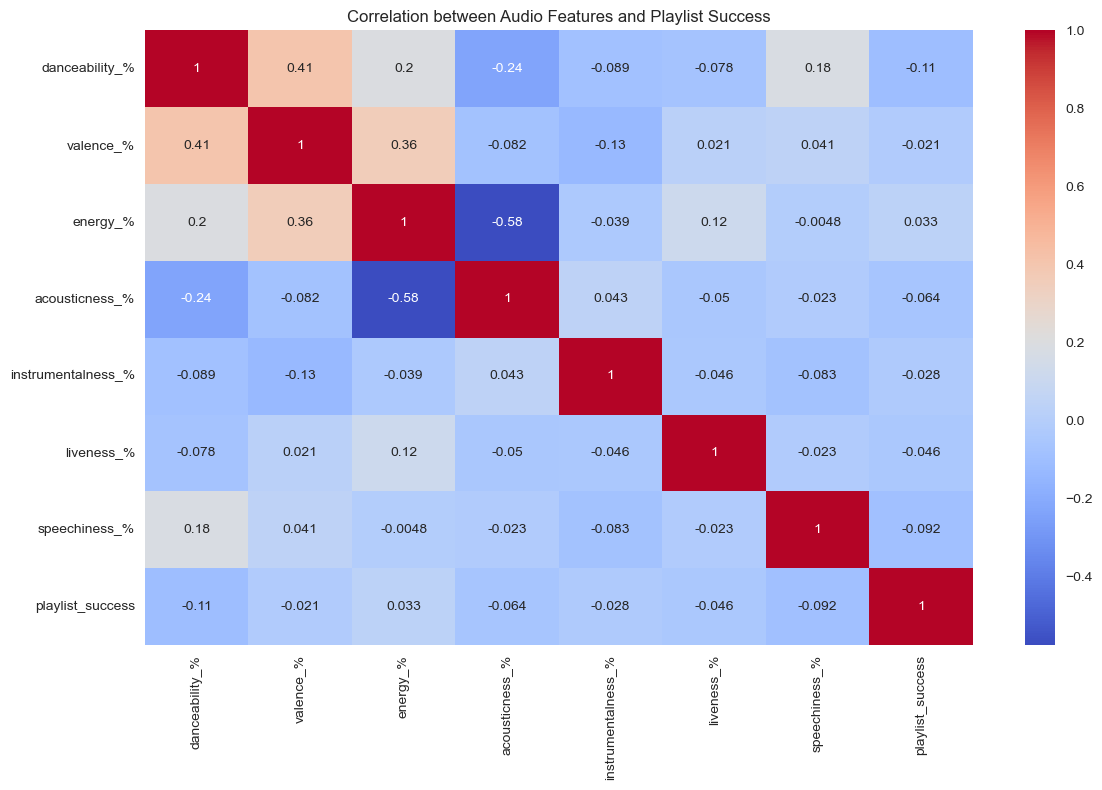

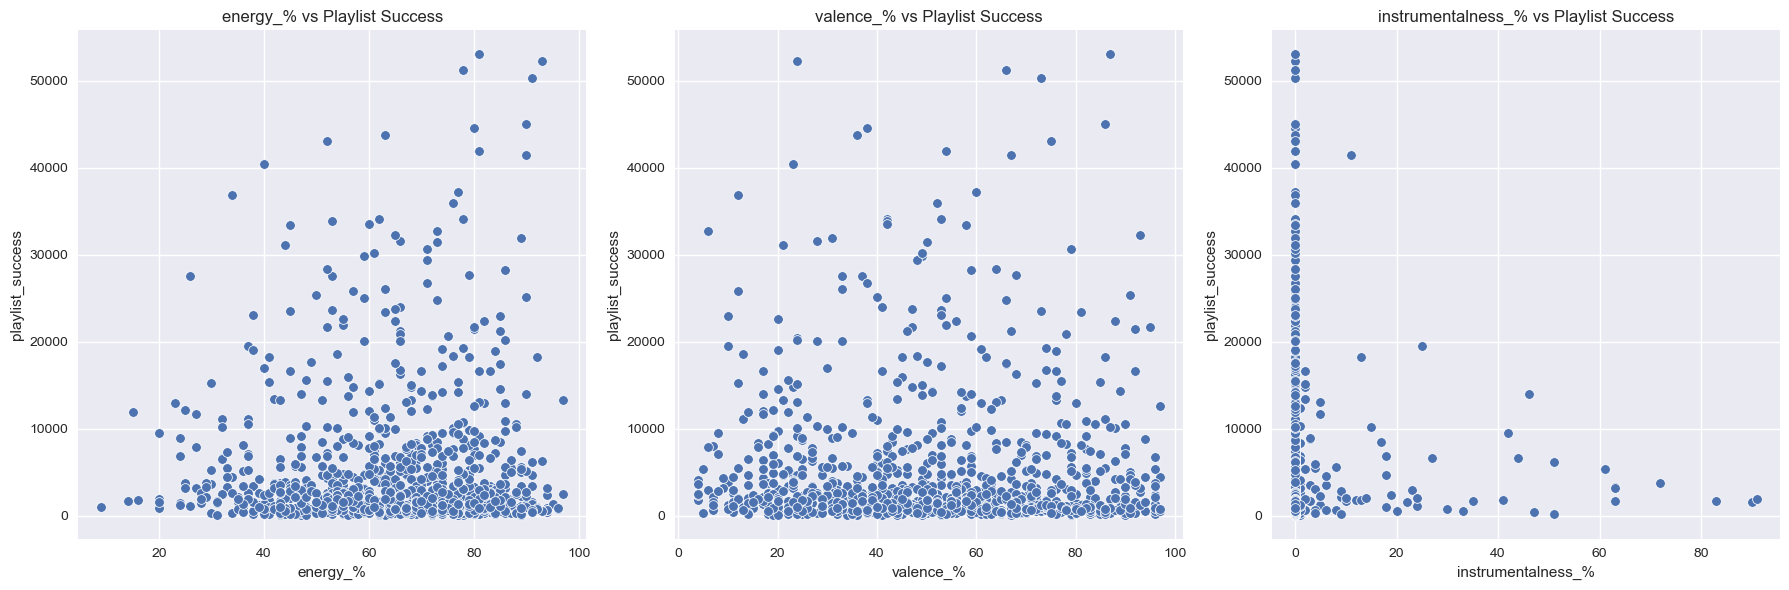


Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58        98
           1       0.55      0.53      0.54        93

    accuracy                           0.56       191
   macro avg       0.56      0.56      0.56       191
weighted avg       0.56      0.56      0.56       191



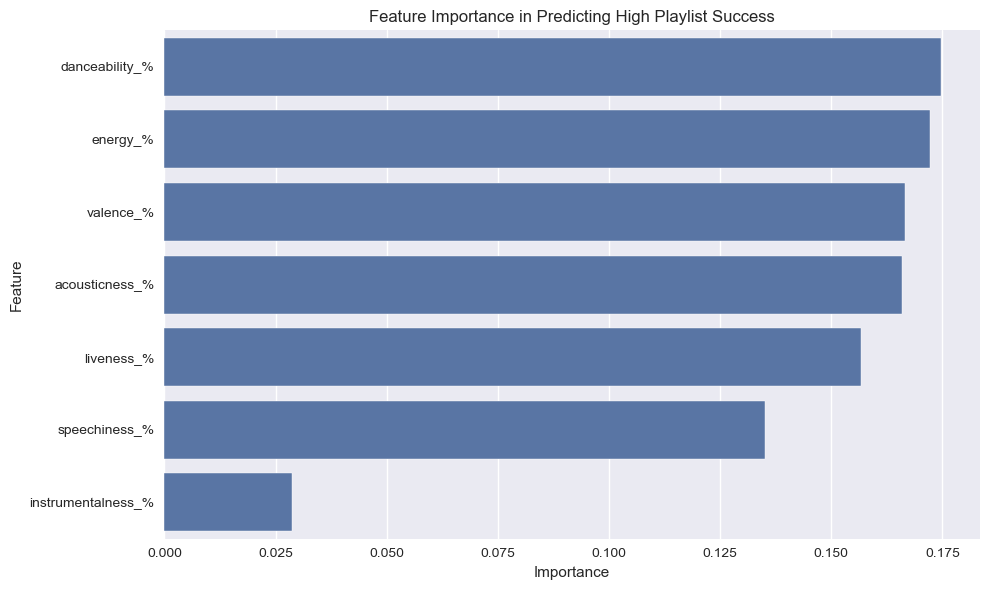

In [44]:
# Create playlist success metric, analyse correlation between this and audio features, visualise relationships and build a model to predict playlist inclusion

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 1. Create a "playlist success" metric
df['playlist_success'] = df['in_spotify_playlists'] + df['in_apple_playlists'] + df['in_deezer_playlists']

# Create a binary classification target
df['high_playlist_success'] = (df['playlist_success'] > df['playlist_success'].median()).astype(int)

# 2. Analyze correlation between playlist success and audio features
audio_features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
correlation = df[audio_features + ['playlist_success']].corr()['playlist_success'].sort_values(ascending=False)

print("Correlation between audio features and playlist success:")
print(correlation)

# 3. Visualize relationships
plt.figure(figsize=(12, 8))
sns.heatmap(df[audio_features + ['playlist_success']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Audio Features and Playlist Success')
plt.tight_layout()
plt.show()

# Scatter plots for top correlated features
top_features = correlation.index[1:4]  # Exclude 'playlist_success' itself
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, feature in enumerate(top_features):
    sns.scatterplot(x=feature, y='playlist_success', data=df, ax=axes[i])
    axes[i].set_title(f'{feature} vs Playlist Success')
plt.tight_layout()
plt.show()

# 4. Build a model to predict playlist inclusion
X = df[audio_features]
y = df['high_playlist_success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

y_pred = rf_classifier.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance for playlist success prediction
feature_importance = pd.DataFrame({'feature': audio_features, 'importance': rf_classifier.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting High Playlist Success')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

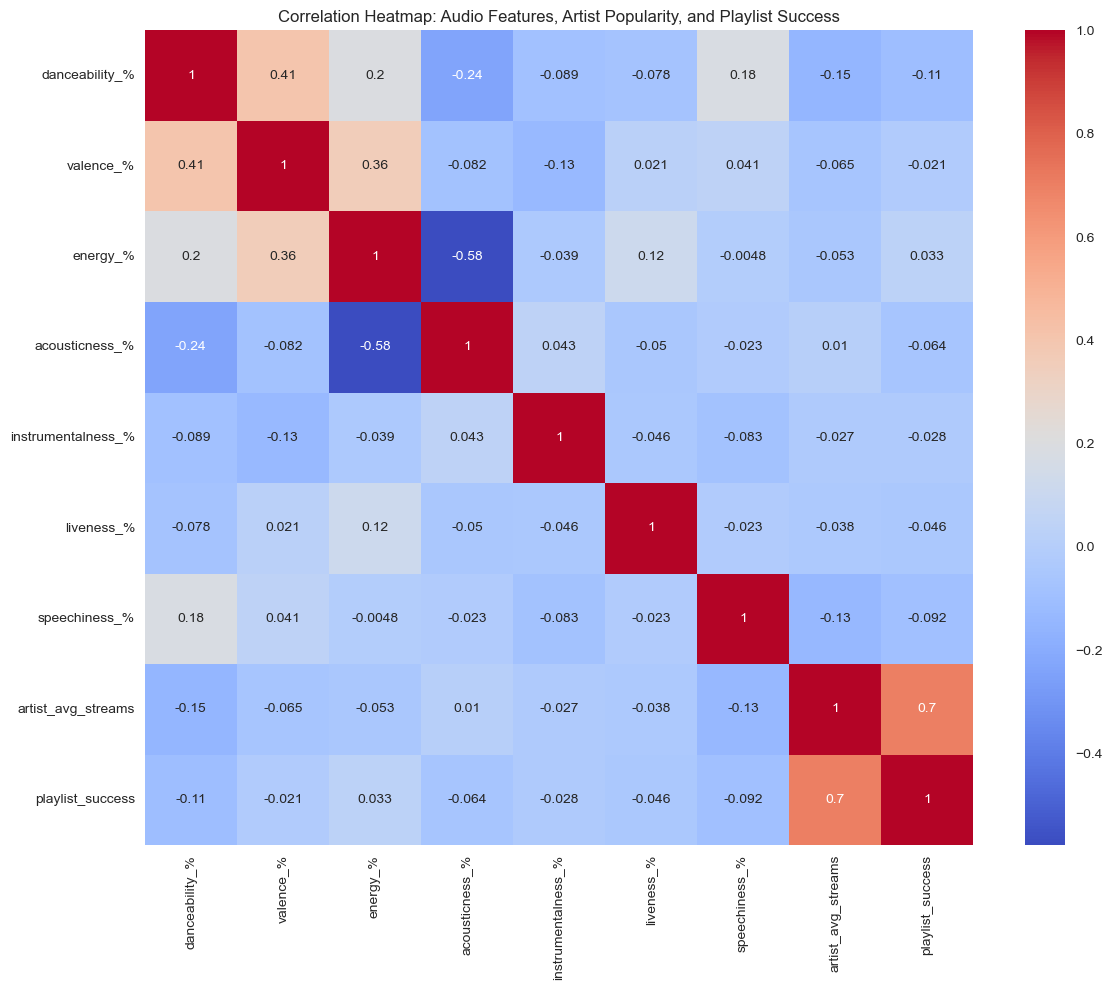

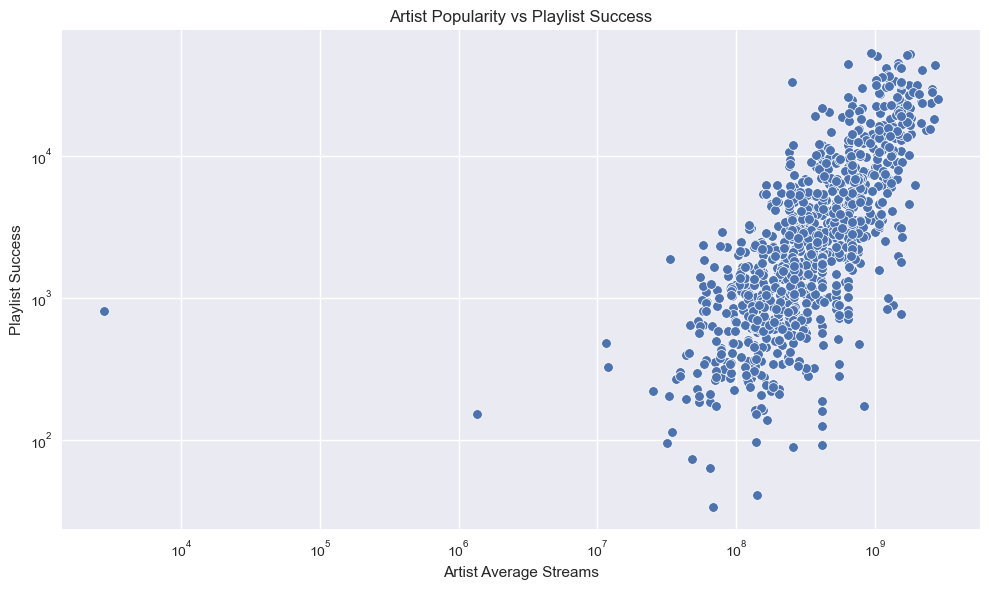

Mean Squared Error: 24236927.931590285
R-squared Score: 0.48663908542863377


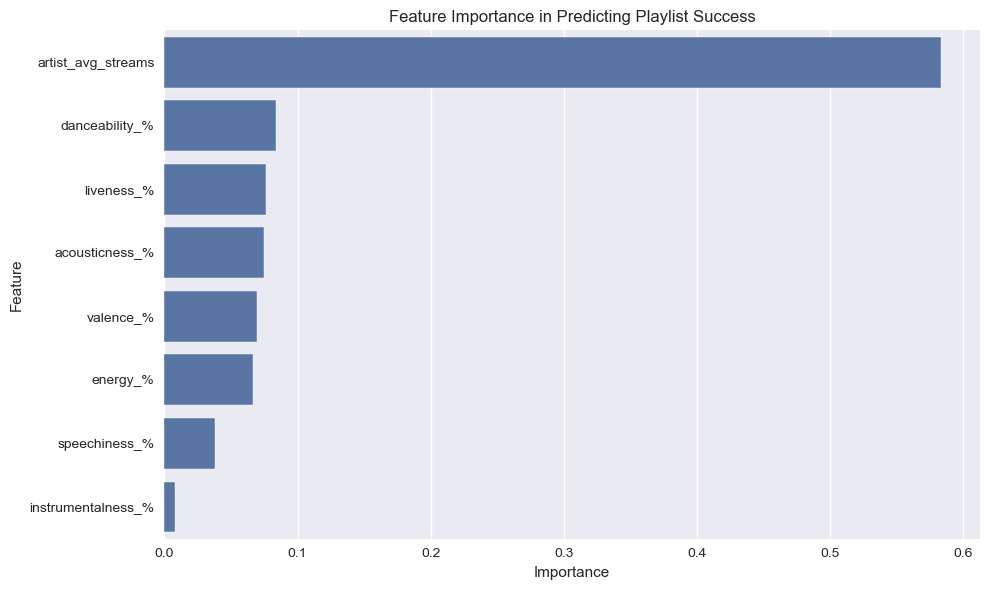

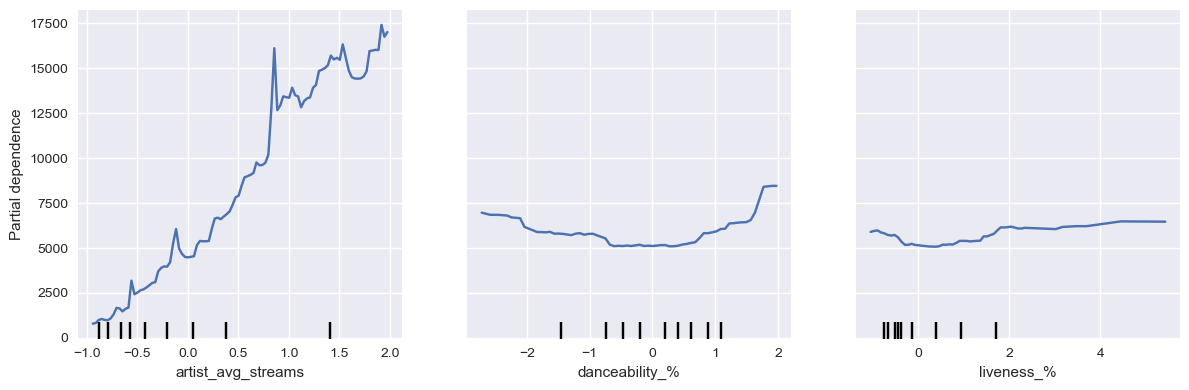

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 1. Create an artist popularity metric
artist_popularity = df.groupby('artist(s)_name')['streams'].mean().reset_index()
artist_popularity.columns = ['artist(s)_name', 'artist_avg_streams']
df = df.merge(artist_popularity, on='artist(s)_name', how='left')

# 2. Analyze relationships
features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'artist_avg_streams', 'playlist_success']
correlation = df[features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Audio Features, Artist Popularity, and Playlist Success')
plt.tight_layout()
plt.show()

# Scatter plot of artist popularity vs playlist success
plt.figure(figsize=(10, 6))
sns.scatterplot(x='artist_avg_streams', y='playlist_success', data=df)
plt.title('Artist Popularity vs Playlist Success')
plt.xlabel('Artist Average Streams')
plt.ylabel('Playlist Success')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

# 3. Build improved model
X = df[features[:-1]]  # Exclude 'playlist_success'
y = df['playlist_success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# 4. Visualize feature importance
feature_importance = pd.DataFrame({'feature': features[:-1], 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Playlist Success')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 5. Partial dependence plots for top features
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 4))
features_to_plot = feature_importance['feature'].head(3).tolist()
PartialDependenceDisplay.from_estimator(rf_model, X_test_scaled, features_to_plot, ax=ax)
plt.tight_layout()
plt.show()